# **Fastai - From Data to DataLoaders (for images)**

As always, first check if you have your GPU accelerator in Colab enabled.
Second, run the cells below to activate the helper functions of fastai, and link it to GDrive.


In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

Since we are going to import data, make sure you have a zip-file which contains your training data. The easiest way to import classification data, is to have a folder for each class you want to predict, and use the folder name as the label.

So, for instance, if you want to make a classification model to predict a dog or a cat, with your own data: make a parentfolder 'data', and in that folder:a folder 'cat' with the cat images, and a folder 'dog' with the dog images. Zip that entire parentfolder, so you get a 'data.zip' file.

We could mount GDrive to Colab, and store our images there. But the I/O is just too slow (but check, because Google continuously changes this behavior).
So we're going to upload this zip file 'data.zip' into our local Colab memory. Keep in mind: for large datasets this would be impossible, and we would therefore need our GCP account to store our data in buckets on the Google Cloud.

To upload the 'data.zip' folder to local colab memory: look to the left of the screen, and click the Filefolder-icon. Click the 'upload to session-storage' icon, select your 'data.zip' file, and upload.
Remember: this data will only stay here for the duration of our session.
But that's long enough for our purposes.

Now, let's unzip our data, so we can access it via our local session storage:

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: photos/African Buffalo/
  inflating: photos/African Buffalo/AfricanBuffaloAfrica0.jpeg  
  inflating: photos/African Buffalo/AfricanBuffaloAfrica1.jpeg  
  inflating: photos/African Buffalo/AfricanBuffaloAfrica10.jpeg  
  inflating: photos/African Buffalo/AfricanBuffaloAfrica100.jpeg  
  inflating: photos/African Buffalo/AfricanBuffaloAfrica101.jpeg  
  inflating: photos/African Buffalo/AfricanBuffaloAfrica102.jpeg  
  inflating: photos/African Buffalo/AfricanBuffaloAfrica103.jpeg  
  inflating: photos/African Buffalo/AfricanBuffaloAfrica104.jpeg  
  inflating: photos/African Buffalo/AfricanBuffaloAfrica105.jpeg  
  inflating: photos/African Buffalo/AfricanBuffaloAfrica106.jpeg  
  inflating: photos/African Buffalo/AfricanBuffaloAfrica107.jpeg  
  inflating: photos/African Buffalo/AfricanBuffaloAfrica108.jpeg  
  inflating: photos/African Buffalo/AfricanBuffaloAfrica109.jpeg  
  inflating: photos/African Buffalo/AfricanBuffaloAfrica11.jpeg  
  inflating:

After running the unzip command, it takes a few moments, but you should see your 'data' folder, with the cat and dog folder inside, pop up in the directory structure on the left.

Let's check one of the images (local colab session storage can be found in the '/content/' directory:

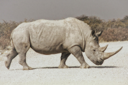

In [ ]:
from PIL import Image
path = '/content/photos/'
im = Image.open(path + 'Rhino/Rhino1.jpeg')
im.to_thumb(128,128)

To make life easier, let's make a variable *filenames* that contains a listing of all paths to all files in the data folder

In [ ]:
from fastai.vision.all import *
filenames = get_image_files(path)
filenames

(#1737) [Path('/content/photos/Leopard/LeopardAfrica12.jpeg'),Path('/content/photos/Leopard/LeopardAfrica343.jpeg'),Path('/content/photos/Leopard/LeopardAfrica233.jpeg'),Path('/content/photos/Leopard/LeopardAfrica71.jpeg'),Path('/content/photos/Leopard/LeopardAfrica331.jpeg'),Path('/content/photos/Leopard/LeopardAfrica81.jpeg'),Path('/content/photos/Leopard/LeopardAfrica36.jpeg'),Path('/content/photos/Leopard/LeopardAfrica209.jpeg'),Path('/content/photos/Leopard/LeopardAfrica7.jpeg'),Path('/content/photos/Leopard/LeopardAfrica8.jpeg')...]

And just as a sanity check, let's verify all the images, to make sure none of them are corrupt files:

In [ ]:
failed = verify_images(filenames)
failed

(#0) []

# **DataLoaders**

To read-in data for our modeling, fastai uses a wrapper class called 'DataLoaders', which can take whatever 'DataLoader' (notice the 's' or lack thereof) objects you pass to it (usually a `train` and a `valid`). And makes them available. 
So, in short: we need DataLoaders as a wrapper around our training and validation data, so other fastai functions can call upon them.

If you want to check out the source code for this function:

In [ ]:
??DataLoaders

Or just a quick summary of the doc:

In [ ]:
doc(DataLoaders)

We already saw some *factory methods* for some common data import options in our previous notebook on taking fastai for a spin. 

ImageDataLoader using a self-defined function on the filenames to load all files in a folder, and add a label to them according to our function.

But we also saw other *factory-methods* of DataLoaders in action: TextDataLoaders, SegmentationDataLoaders, TabularDataLoaders, CollabDataLoaders.

```python
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))
```

```python
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

dls = SegmentationDataLoaders.from_label_func(...)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",...)

dls = CollabDataLoaders.from_csv(path/'ratings.csv')
```

# **Fastai data block API**

So, as we can gather from these predetermined *factory methods*: to get our own data into a DataLoaders object, we need to tell fastai at least 4 things:


1.   What kind of data we are working with
2.   How to get all the data items
3.   How to label these items
4.   How to create the validation set

Okay. Now, let's use a custom, fully adjustable, way to create our own DataLoaders object, so we don't need to use one of those pre-configured loaders. This is done in fastai by using the 'data block API'. 

I'll give you the code first, and then explain it line by line:

In [ ]:
AnimalsAfrica = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
doc(DataBlock)

Let's look at each of these arguments one by one. First we provide a tuple where we specify what types we want for the independent and dependent variables: 

```python
blocks=(ImageBlock, CategoryBlock)
```

The *independent variable* is the thing we are using to make predictions from, and the *dependent variable* is our target. In this case, our independent variables are images, and our dependent variables are the categories (cat or dog) for each image. As you can imagine, there are other types of blocks as well (check the docs if interested).

For this catdogs-`DataLoaders`-object, our underlying items will be file paths. We have to tell fastai how to get a list of those files. The `get_image_files` function takes a path, and returns a list of all of the images in that path (recursively, by default):

```python
get_items=get_image_files
```

Next, we want to split our training and validation sets randomly. However, we would like to have the same training/validation split each time we run this notebook, so we fix the random seed (computers don't really know how to create random numbers at all, but simply create lists of numbers that look random; if you provide the same starting point for that list each time—called the *seed*—then you will get the exact same list each time):


```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```

The independent variable is often referred to as `X` and the dependent variable is often referred to as `y`. Here, we are telling fastai what function to call to create the labels in our dataset:

```python
get_y=parent_label
```

`parent_label` is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our cat/dog images into folders based on the type of animal, this is going to give us the labels that we need. This a very common way to structure your input data, also on the Kaggle platform. That's why fastai has a build-in method for it. Pretty handy, no?

If you download / scrape images from the internet, they could all be of different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them at once (what we call a *mini-batch*). 

To group them in a big array (a *tensor*), that is going to go through our model in parallel, they all need to be of the same size (the library needs to know how many input-neurons it should have - was the same in TensorFlow/Keras). 

So, we need to add a transform which will resize all these images to the same size. *Item transforms* (item_tfms) are pieces of code that run on each individual item, whether it's an image, category, or so whatever. fastai includes many predefined transforms; we'll use the `Resize` transform here, to resize all images to 128x128 pixels

```python
item_tfms=Resize(128)
```


In [ ]:
doc(Resize)

Alright, so now we have our `DataBlock` object *catdogs*. This is like a boilerplate, or a template to create our custom `DataLoaders`. All we have to do, is feed it the path to where it can find the data, and it will take care of the rest: loading the data into train/valid sets we can directly use in fastai, which will hand it over as tensors to the GPU's to do their magic.

Awesome! 
Let's load it up, Scotty! 

In [ ]:
dls = AnimalsAfrica.dataloaders(path)

By default, fastai will load 64 images at a time, stacked up as one big multidimensional tensor. So default batch_size = 64.

Let's do a quick sanity check of our data

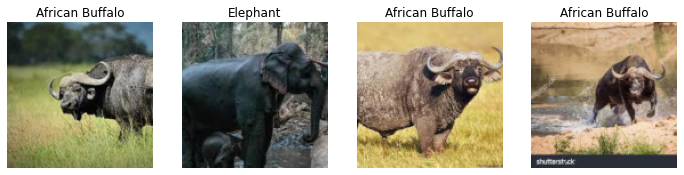

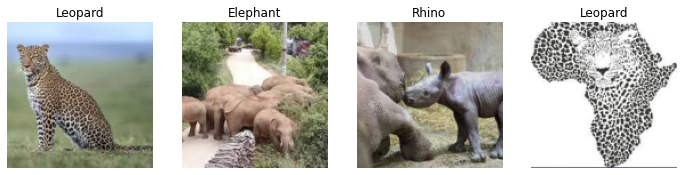

In [ ]:
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

Ofcourse, default resizing to a square 128x128 isn't always the best option, because by default the resizing operation *crops* (cutting off pieces) to images to the requested size. Sometimes images are really rectangular, and that forced cropping, can really *morph* your images.

We can try Squishing instead of cropping, or padding with 'zero's', but these are kind of wastefull: squishing will *morph* our images for sure, and than our model won't detect correct patterns. And padding is just empty space, but we still need lot's of calculations (the convolutions) to calculate with it, but it's just pure empty space, so a complete waste of resources...



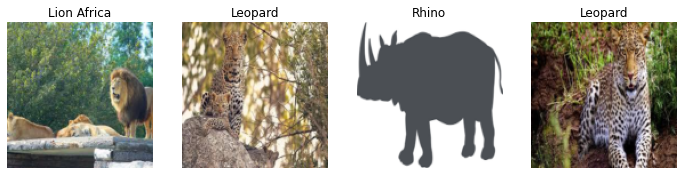

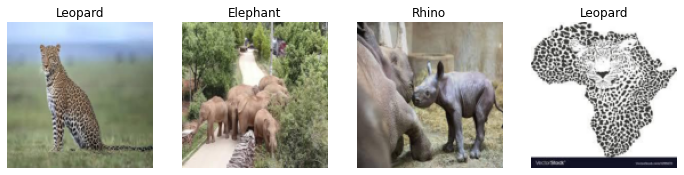

In [ ]:
AnimalsAfrica = AnimalsAfrica.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = AnimalsAfrica.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

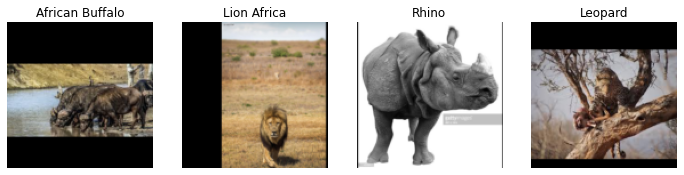

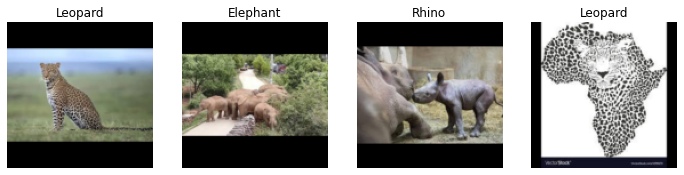

In [ ]:
AnimalsAfrica = AnimalsAfrica.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = AnimalsAfrica.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

In fact, trials and research show, it's usually best to do a kind of random Resized cropping. So randomly selecting a part of the image, and crop to just that part. But ofcourse, because it's random, every epoch (epoch = 1 entire run through all your data), another random section of the image is chosen. So every epoch your network will focus on differnt parts of the images. Best is to give this transform a minimum size, the absolute minimum piece of the image it can crop it down to, otherwise it might randomly select a teeny tiny piece...

This is kind of an augmentation technique (which is also a regularization technique = preventing overfitting or fixating on certain features)

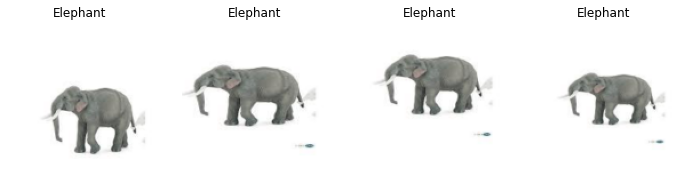

In [ ]:
AnimalsAfrica = AnimalsAfrica.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = AnimalsAfrica.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)
# the unique=True piece here is just to force our sanity check to give us the same image over and over again, 
# ofcourse each time with the random transform applied to it

Awesome! Now we're making some headway!

Ofcourse, we can add some more augmentation to really level-up on the input quality, but that's for another notebook.

Let's just end this one, with a simple out of the box convolutional neural net, using transfer-learning (see later lesson), so using a resnet with pretrained weights, fine-tune it automatically, and let's just see how good our model is already...

Next time, we'll level up on these techniques, but for now, let's just use an out of the box technique...

In [ ]:
our_out_of_the_box_model = cnn_learner(dls, resnet50, metrics=error_rate)
our_out_of_the_box_model.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.130101,0.524213,0.121037,00:13


epoch,train_loss,valid_loss,error_rate,time


In [ ]:
interp = ClassificationInterpretation.from_learner(our_out_of_the_box_model)
interp.plot_confusion_matrix()

Okay, this is just on a tiny dataset...but not bad...Only 2 wrong out of the 20 on the validation set...let's see which 2...

In [ ]:
interp.plot_top_losses(2, nrows=1)

(if the top losses function only draws one image, check: https://forums.fast.ai/t/plot-top-losses-problem/92015/10 for a fix)
Okay. Fair enough...probably with some more data, and augmentation techniques, and some more awesome level_ups we would be better at this...but not bad at all for our first run at it!

Let's save and export our model, so we can deploy it later to be used in a webpage.

In [ ]:
# saving our model, by default in a folder called 'models'.
our_out_of_the_box_model.save('first_model')
#creating an serialized pickle object of our model, the export.pkl file
our_out_of_the_box_model.export()

Make sure you manually download the export.pkl file (and the first_model.pth if need be)! Because Colab will remove files in its session memory after the session is complete. Plus, later on, we will run a Flask API service on our local machine, so we need the serialized model.

In [ ]:
ls

# **Loading a model & inference:**

In [ ]:
our_out_of_the_box_model_inference = load_learner('export.pkl')
# let's test our model on an image
our_out_of_the_box_model_inference.predict(path + 'Rhino/Rhino1.jpeg')
# this will return the predicted category, the index of this predicted category, and the probabilities of each category

In [ ]:
our_out_of_the_box_model_inference.dls.vocab

Alright! So we can load our serialized model, hand it an image, and it will return a prediction.

Next step is ofcourse making a Python API wrapper around this model, so we can use JSON to upload an image, and get the predictions returned. This is where Flask comes in! Flask is a Python micro framework, with a really easy to use API wrapper. 

Now, you should already have enough information to go ahead and build a prototype of your Computer Vision project assignment! You could even start to research a little bit around Flask API and how they are used to 'deploy', or provide an interface to, a serialized (pickle) Deep Learning model...